## cargar librerias y constantes

# entrenar el primer modelo

In [1]:
!pip install keras
!pip install tensorflow
!pip install opencv-python
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, Input
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.utils import to_categorical
import os
import numpy as np
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import json

# Cargar constantes desde el archivo JSON
with open('config.json', 'r') as config_file:
    config = json.load(config_file)

# Constantes
CONST_BASE_FOLDER = config["CONST_BASE_FOLDER"]
CONST_OUTPUT_WIDTH = config["CONST_OUTPUT_WIDTH"]
#CONST_FILLBG_COLOR = tuple(config["CONST_FILLBG_COLOR"])
PRODUCTION_DATASET_FOLDER = os.path.join(CONST_BASE_FOLDER, "production_dataset_52_resize_2/transformed_dataset")
TRAIN_DATA_DIR = os.path.join(PRODUCTION_DATASET_FOLDER, 'train') 
VALIDATION_DATA_DIR = os.path.join(PRODUCTION_DATASET_FOLDER, 'valid')
batch_size = 32
# Definir el número de épocas
epochs = 50

# Definir el tamaño de las imágenes
width_shape = 224
height_shape = 224

# Definir el número de clases
num_classes = 52  # Ajustar según el número de clases en tu dataset


In [ ]:
## definir los generadores de imagenes y los generadores de imagenes por lotes


In [2]:
# Definir el generador de imágenes para el conjunto de entrenamiento con aumentos de datos
train_datagen = ImageDataGenerator(
    rotation_range=20,               # Rango de grados para rotación aleatoria
    zoom_range=0.2,                  # Rango de zoom aleatorio
    width_shift_range=0.1,           # Rango de desplazamiento horizontal aleatorio
    height_shift_range=0.1,          # Rango de desplazamiento vertical aleatorio
    horizontal_flip=True,            # Volteo horizontal aleatorio
    vertical_flip=False,             # No se aplica volteo vertical
    preprocessing_function=preprocess_input)  # Función de preprocesamiento

# Definir el generador de imágenes para el conjunto de validación con los mismos aumentos de datos
valid_datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    preprocessing_function=preprocess_input)

# Crear un generador de lotes de imágenes para el conjunto de entrenamiento
train_generator = train_datagen.flow_from_directory(
    TRAIN_DATA_DIR,                  # Directorio que contiene las imágenes de entrenamiento
    target_size=(width_shape, height_shape),  # Tamaño al que se redimensionarán las imágenes
    batch_size=batch_size,           # Tamaño del lote
    class_mode='categorical')        # Modo de clasificación para imágenes categóricas

# Crear un generador de lotes de imágenes para el conjunto de validación
validation_generator = valid_datagen.flow_from_directory(
    VALIDATION_DATA_DIR,             # Directorio que contiene las imágenes de validación
    target_size=(width_shape, height_shape),  # Tamaño al que se redimensionarán las imágenes
    batch_size=batch_size,           # Tamaño del lote
    class_mode='categorical')        # Modo de clasificación para imágenes categóricas

train_generator = train_generator.repeat()  # Esto hace que el generador se repita durante las épocas
validation_generator = validation_generator.repeat()  # Lo mismo para el generador de validación


Found 8320 images belonging to 52 classes.
Found 2080 images belonging to 52 classes.


# entrenar el modelo


In [3]:

# Definir el número de muestras de entrenamiento y validación
nb_train_samples = 8320
nb_validation_samples = 2080

# Definir la entrada de la red neuronal con el tamaño de las imágenes
image_input = Input(shape=(width_shape, height_shape, 3))

# Cargar el modelo VGG16 preentrenado con pesos ajustados desde ImageNet
model = VGG16(input_tensor=image_input, include_top=True, weights='imagenet')

# Obtener la salida de la penúltima capa densa del modelo VGG16 (fc2)
last_layer = model.get_layer('fc2').output

# Añadir una nueva capa densa al final del modelo para la clasificación multiclase con regularización L2 (Evita sobreajuste)
out = Dense(num_classes, activation='softmax', kernel_regularizer='l2', name='output')(last_layer)

# Crear un nuevo modelo personalizado que toma la entrada de la imagen y produce la salida clasificada
custom_vgg_model = Model(image_input, out)

# Congelar todas las capas del modelo, excepto la capa densa añadida
for layer in custom_vgg_model.layers[:-1]:
    layer.trainable = False

# Compilar el modelo con una función de pérdida, optimizador y métricas especificadas
custom_vgg_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])


# Mostrar un resumen del modelo que incluye la arquitectura y el número de parámetros
custom_vgg_model.summary()

# Entrenar el modelo utilizando generadores de datos para el conjunto de entrenamiento y validación
model_history = custom_vgg_model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    steps_per_epoch=nb_train_samples//batch_size,  # Número de pasos por época de entrenamiento
    validation_steps=nb_validation_samples//batch_size)  # Número de pasos por época de validación


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 52)             │       213,044 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,473,588 (512.98 MB)

 Trainable params: 213,044 (832.20 KB)

 Non-trainable params: 134,260,544 (512.16 MB)

C:\Users\Sebastian\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 2010s 8s/step - accuracy: 0.1034 - loss: 4.9748 - val_accuracy: 0.3298 - val_loss: 3.4021
Epoch 2/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/50


C:\Users\Sebastian\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


260/260 ━━━━━━━━━━━━━━━━━━━━ 1907s 7s/step - accuracy: 0.3744 - loss: 3.1692 - val_accuracy: 0.4101 - val_loss: 2.9553
Epoch 4/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1908s 7s/step - accuracy: 0.4711 - loss: 2.7073 - val_accuracy: 0.4553 - val_loss: 2.6891
Epoch 6/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 239us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1907s 7s/step - accuracy: 0.5298 - loss: 2.4429 - val_accuracy: 0.4933 - val_loss: 2.5059
Epoch 8/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 241us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 2033s 8s/step - accuracy: 0.5694 - loss: 2.2474 - val_accuracy: 0.5216 - val_loss: 2.3778
Epoch 10/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 232us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 11/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 2376s 9s/step - accuracy: 0.5868 - loss: 2.1183 - val_accuracy: 0

## busca si ya hay modelos con el mismo nombre y guarda el modelo

In [9]:
import os

# Nombre base del modelo
model_name = "model_VGG16_v"

# Extensión del archivo
file_extension = ".keras"

# Directorio donde se guardarán los modelos
model_directory = os.path.join(CONST_BASE_FOLDER, "production_dataset_52_resize_2/transformed_dataset")

# Inicializar contador
counter = 1

# Generar el nombre completo del archivo
file_name = model_name + file_extension

ruta=model_directory + file_name
print(ruta)
# Verificar si el modelo ya está guardado
while os.path.exists(model_directory + file_name):

    # Si el archivo existe, agregar un número al final del nombre del modelo
    file_name = f"{model_name}{counter}{file_extension}"
    counter += 1

# Guardar el modelo con el nombre único en el directorio correcto
custom_vgg_model.save(model_directory + file_name)

E:\OneDrive - Universidad Cooperativa de Colombia\production_dataset_52_resize_2/transformed_datasetmodel_VGG16_v.keras


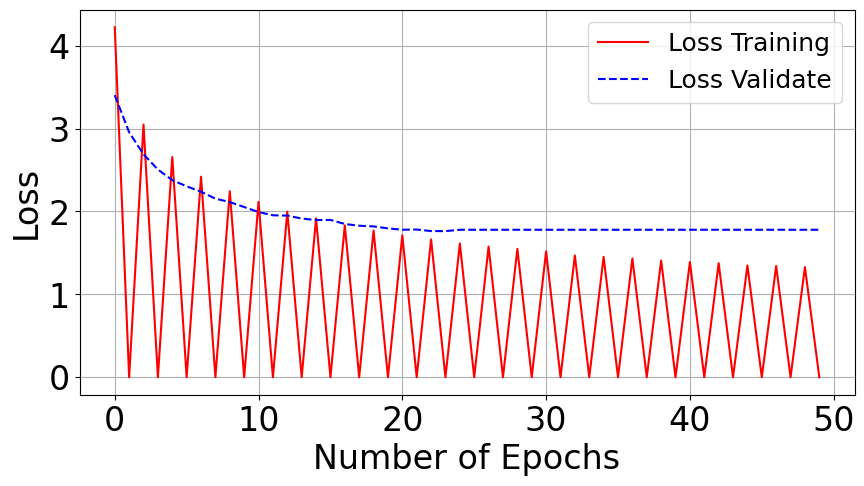

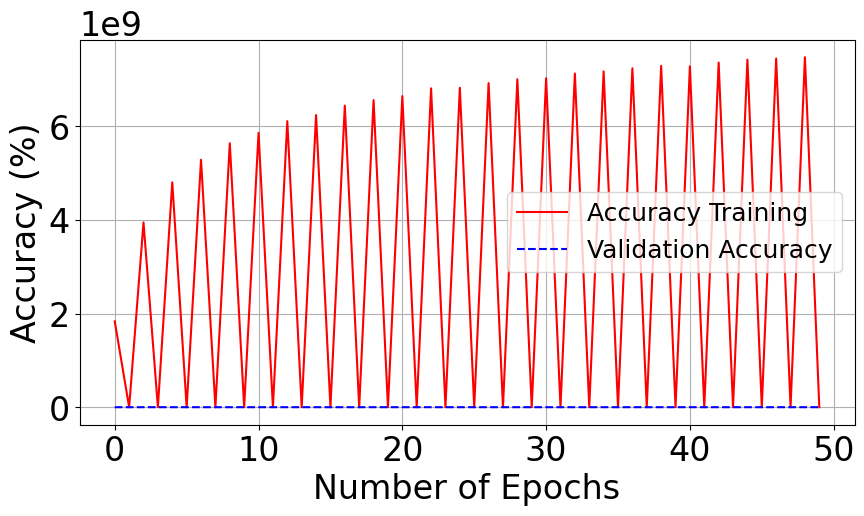

In [39]:
def extend_to_50(data):
    return data + [data[-1]] * (50 - len(data))
    
def plotTraining(hist, typeData):

    # Seleccionar la figura y establecer el tamaño
    # Dependiendo del tipo de datos (loss o accuracy), se elige la figura correspondiente

    if typeData=="loss":
        plt.figure(1, figsize=(10, 5))
        yc = extend_to_50(hist.history['loss'])
        plt.ylabel('Loss', fontsize=24)
        plt.plot(range(epochs), yc, '-r', label='Loss Training')
    if typeData=="accuracy":
        plt.figure(2, figsize=(10, 5))
        yc = extend_to_50([100 * acc for acc in hist.history['accuracy']])
        plt.ylabel('Accuracy (%)', fontsize=24)
        plt.plot(range(epochs), yc, '-r', label='Accuracy Training')
    if typeData=="val_loss":
        plt.figure(1, figsize=(10, 5))
        yc = extend_to_50(hist.history['val_loss'])
        plt.ylabel('Loss', fontsize=24)
        plt.plot(range(epochs), yc, '--b', label='Loss Validate')
    if typeData=="val_accuracy":
        plt.figure(2, figsize=(10, 5))
        yc = extend_to_50([100 * acc for acc in hist.history['val_accuracy']])
        plt.ylabel('Accuracy (%)', fontsize=24)
        plt.plot(range(epochs), yc, '--b', label='Validation Accuracy')


    plt.rc('xtick',labelsize=24)
    plt.rc('ytick',labelsize=24)
    plt.rc('legend', fontsize=18)
    plt.legend()
    plt.xlabel('Number of Epochs',fontsize=24)
    plt.grid(True)
    
# Ejemplo de uso
plotTraining(model_history, "loss")
plotTraining(model_history, "accuracy")
plotTraining(model_history, "val_loss")
plotTraining(model_history, "val_accuracy")


In [ ]:
# parte del codigo para consumir un modelo
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.models import load_model

names = ['CYANOCORAX YNCAS', 'PIRANGA RUBRA', 'PITANGUS SULPHURATUS', 'PYROCEPHALUS RUBINUS', 'RUPORNIS MAGNIROSTRIS', 'SICALIS FLAVEOLA', 'THRAUPIS EPISCOPUS', 'TIARIS OLIVACEUS', 'TYRANNUS MELANCHOLICUS', 'ZONOTRICHIA CAPENSIS', 'CATHARTES AURA', 'COEREBA FLAVEOLA', 'COLUMBA LIVIA', 'CORAGYPS ATRATUS', 'CROTOPHAGA SULCIROSTRIS', 'CYANOCORAX YNCAS', 'EGRETTA THULA', 'FALCO PEREGRINUS', 'FALCO SPARVERIUS', 'HIRUNDO RUSTICA', 'PANDION HALIAETUS', 'PILHERODIUS PILEATUS', 'PITANGUS SULPHURATUS', 'PYRRHOMYIAS CINNAMOMEUS', 'RYNCHOPS NIGER', 'SETOPHAGA FUSCA', 'SYNALLAXIS AZARAE', 'TYRANNUS MELANCHOLICUS']

# Cargar el modelo
modelt = load_model('models/optimizado.keras')
#modelt = custom_vgg_model

# Ruta de la imagen de prueba
imaget_path = "ImagenPrueba_sin_fondo.jpg"

# Leer la imagen, cambiar tamaño y preprocesar
imaget=cv2.resize(cv2.imread(imaget_path), (width_shape, height_shape), interpolation = cv2.INTER_AREA)
xt = np.asarray(imaget)
xt=preprocess_input(xt)
xt = np.expand_dims(xt,axis=0)

# Obtener las predicciones del modelo
preds = modelt.predict(xt)

# Obtener la clase predicha y su porcentaje de confianza
predicted_class_index = np.argmax(preds)
predicted_class_name = names[predicted_class_index]
confidence_percentage = preds[0][predicted_class_index] * 100

# Imprimir el resultado
print(f'Clase predicha: {predicted_class_name}')
print(f'Porcentaje de confianza: {confidence_percentage:.2f}%')

# Mostrar la imagen
plt.imshow(cv2.cvtColor(np.asarray(imaget), cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [43]:
!pip install mlxtend
##mostrar estadisticas
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


names = ['CATHARTES AURA', 'COEREBA FLAVEOLA', 'COLUMBA LIVIA', 'CORAGYPS ATRATUS', 'CROTOPHAGA SULCIROSTRIS', 'CYANOCORAX YNCAS', 'EGRETTA THULA', 'FALCO PEREGRINUS', 'FALCO SPARVERIUS', 'HIRUNDO RUSTICA', 'PANDION HALIAETUS', 'PILHERODIUS PILEATUS', 'PITANGUS SULPHURATUS', 'PYRRHOMYIAS CINNAMOMEUS', 'RYNCHOPS NIGER', 'SETOPHAGA FUSCA', 'SYNALLAXIS AZARAE', 'TYRANNUS MELANCHOLICUS']



test_data_dir = VALIDATION_DATA_DIR

test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(width_shape, height_shape),
    batch_size = batch_size,
    class_mode='categorical',
    shuffle=False)

custom_Model= load_model(model_directory + file_name)

predictions = custom_Model.predict(test_generator)


y_pred = np.argmax(predictions, axis=1)
y_real = test_generator.classes


matc=confusion_matrix(y_real, y_pred)



print(metrics.classification_report(y_real,y_pred, digits = 4))

   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   --- ------------------------------------ 0.1/1.4 MB 2.2 MB/s eta 0:00:01
   ----------------- ---------------------- 0.6/1.4 MB 6.2 MB/s eta 0:00:01
   ------------------------------- -------- 1.1/1.4 MB 7.5 MB/s eta 0:00:01
   ---------------------------------------  1.4/1.4 MB 7.8 MB/s eta 0:00:01
   ---------------------------------------  1.4/1.4 MB 7.8 MB/s eta 0:00:01
   ---------------------------------------- 1.4/1.4 MB 6.2 MB/s eta 0:00:00
Found 2080 images belonging to 52 classes.
65/65 ━━━━━━━━━━━━━━━━━━━━ 377s 6s/step
              precision    recall  f1-score   support

           0     0.3143    0.5500    0.4000        40
           1     0.4074    0.2750    0.3284        40
           2     0.2766    0.3250    0.2989        40
           3     0.2778    0.2500    0.2632        40
           4     0.2812    0.2250    0.2500        4

# todos los modelos

In [ ]:
# Importaciones necesarias
import time
import psutil
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Definir el número de muestras de entrenamiento y validación
nb_train_samples = 2621
nb_validation_samples = 738

# Definir el número de épocas
epochs = 50

# Definir el tamaño de las imágenes
width_shape = 224
height_shape = 224

# Definir el número de clases
num_classes = 18  # Ajustar según el número de clases en tu dataset

# Directorios de datos de entrenamiento y validación
train_data_dir = 'datasetpreprocesado/train'
validation_data_dir = 'datasetpreprocesado/valid'

# Función para crear y entrenar el modelo
def create_and_train_vgg16_model(learning_rate, l2_regularization, batch_size):
    # Crear generadores de datos con el batch_size proporcionado
    train_datagen = ImageDataGenerator(
        rotation_range=20,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=False,
        preprocessing_function=preprocess_input
    )

    valid_datagen = ImageDataGenerator(
        rotation_range=20,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=False,
        preprocessing_function=preprocess_input
    )

    train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(width_shape, height_shape),
        batch_size=batch_size,
        class_mode='categorical'
    )

    validation_generator = valid_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(width_shape, height_shape),
        batch_size=batch_size,
        class_mode='categorical'
    )

    # Definir la entrada de la red neuronal con el tamaño de las imágenes
    image_input = Input(shape=(width_shape, height_shape, 3))

    # Cargar el modelo VGG16 preentrenado con pesos ajustados desde ImageNet
    model = VGG16(input_tensor=image_input, include_top=False, weights='imagenet')

    # Aplanar la salida del VGG16
    x = Flatten()(model.output)

    # Añadir una nueva capa densa al final del modelo para la clasificación multiclase con regularización L2
    out = Dense(num_classes, activation='softmax', kernel_regularizer='l2')(x)

    # Crear un nuevo modelo personalizado que toma la entrada de la imagen y produce la salida clasificada
    custom_vgg_model = Model(inputs=model.input, outputs=out)

    # Congelar todas las capas del modelo base VGG16
    for layer in model.layers:
        layer.trainable = False

    # Compilar el modelo con una función de pérdida, optimizador y métricas especificadas
    custom_vgg_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])

    # Mostrar un resumen del modelo que incluye la arquitectura y el número de parámetros
    custom_vgg_model.summary()

    # Medir el tiempo y el uso de CPU/memoria antes de entrenar
    start_time = time.time()
    start_cpu = psutil.cpu_percent(interval=None)
    start_memory = psutil.virtual_memory().used

    # Crear los callbacks para Early Stopping y guardar el mejor modelo
    checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, restore_best_weights=True)

    # Entrenar el modelo utilizando generadores de datos para el conjunto de entrenamiento y validación
    model_history = custom_vgg_model.fit(
        train_generator,
        epochs=epochs,
        validation_data=validation_generator,
        steps_per_epoch=nb_train_samples // batch_size,
        validation_steps=nb_validation_samples // batch_size,
        callbacks=[checkpoint, early_stopping]
    )

    # Medir el tiempo y el uso de CPU/memoria después de entrenar
    end_time = time.time()
    end_cpu = psutil.cpu_percent(interval=None)
    end_memory = psutil.virtual_memory().used

    # Calcular métricas de tiempo y uso de recursos
    elapsed_time = end_time - start_time
    cpu_usage = end_cpu - start_cpu
    memory_usage = end_memory - start_memory

    print(f"Tiempo transcurrido para el entrenamiento: {elapsed_time} segundos")
    print(f"Uso de CPU durante el entrenamiento: {cpu_usage}%")
    print(f"Aumento en uso de memoria: {memory_usage / (1024 ** 3)} GB")

    return model_history, elapsed_time, cpu_usage, memory_usage

# Definir rangos de búsqueda para hiperparámetros
learning_rates = [0.0001, 0.0005, 0.001]
l2_regularizations = [0.01, 0.05, 0.1]
batch_sizes = [16, 32, 64]

# Variables para almacenar los mejores hiperparámetros y su rendimiento
best_val_accuracy = 0
best_hyperparams = {}

# Realizar la búsqueda de cuadrícula
for learning_rate in learning_rates:
    for l2_regularization in l2_regularizations:
        for batch_size in batch_sizes:
            # Crear y entrenar el modelo con los hiperparámetros actuales
            model_history, elapsed_time, cpu_usage, memory_usage = create_and_train_vgg16_model(learning_rate, l2_regularization, batch_size)

            # Obtener la mejor precisión de validación de esta combinación de hiperparámetros
            val_accuracy = np.max(model_history.history['val_accuracy'])

            # Imprimir los resultados
            print(f"Resultados para lr={learning_rate}, l2={l2_regularization}, batch_size={batch_size}:")
            print(f"Tiempo: {elapsed_time} segundos, CPU: {cpu_usage}%, Memoria: {memory_usage / (1024 ** 3)} GB")
            print(f"Precisión de validación: {val_accuracy}")

            # Actualizar los mejores hiperparámetros si la precisión de validación mejora
            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy
                best_hyperparams = {
                    'learning_rate': learning_rate,
                    'l2_regularization': l2_regularization,
                    'batch_size': batch_size,
                    'val_accuracy': val_accuracy,
                    'elapsed_time': elapsed_time,
                    'cpu_usage': cpu_usage,
                    'memory_usage': memory_usage
                }

# Imprimir los mejores hiperparámetros y su rendimiento
print("Mejores hiperparámetros encontrados:")
print(best_hyperparams)

